In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
import torch.autograd as autograd

class Generator1D(nn.Module):
    def __init__(self, noise_dim=64, cond_dim=5, signal_len=450):
        super().__init__()
        self.signal_len = signal_len
        input_dim = noise_dim + cond_dim

        self.fc = nn.Linear(input_dim, 64 * 16)  # menší než dřív

        self.net = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),  # 16→32
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),  # 32→64
            nn.BatchNorm1d(16),
            nn.ReLU(True),

            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),   # 64→128
            nn.BatchNorm1d(8),
            nn.ReLU(True),

            nn.ConvTranspose1d(8, 4, kernel_size=4, stride=2, padding=1),    # 128→256
            nn.BatchNorm1d(4),
            nn.ReLU(True),

            nn.Conv1d(4, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

        # dynamické měření délky
        with torch.no_grad():
            dummy = torch.zeros(1, input_dim)
            dummy = self.fc(dummy).view(1, 64, 16)
            dummy_out = self.net(dummy)
            self.generated_len = dummy_out.size(2)

    def forward(self, noise, cond):
        x = torch.cat([noise, cond], dim=1)
        x = self.fc(x).view(-1, 64, 16)
        x = self.net(x)

        # zarovnání na přesnou délku signálu
        if x.size(2) > self.signal_len:
            x = x[:, :, :self.signal_len]
        elif x.size(2) < self.signal_len:
            pad_len = self.signal_len - x.size(2)
            x = F.pad(x, (0, pad_len))

        return x.squeeze(1)  # (batch, signal_len)

class Discriminator1D(nn.Module):
    def __init__(self, cond_dim=5, signal_len=450):
        super().__init__()
        self.signal_len = signal_len
        self.cond_dim = cond_dim

        self.conv = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  
        
            nn.Conv1d(8, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),   
        
            nn.Conv1d(16, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv1d(32, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # dynamicky zjistíme velikost
        with torch.no_grad():
            dummy = torch.zeros(1, 1, signal_len)
            conv_out = self.conv(dummy)
            conv_out_size = conv_out.view(1, -1).size(1)

        self.out = nn.Sequential(
            nn.Linear(conv_out_size + cond_dim, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 1)  # jen skóre (žádná sigmoid)
        )

    def forward(self, signal, cond):
        x = signal.unsqueeze(1)  # (batch,1,L)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, cond], dim=1)
        return self.out(x)


class Signal1DDataset(Dataset):
    def __init__(self, root_dir, params_csv, allowed_experiments=None,
                 normalize_signals=True, normalize_conditions=True):
        self.root_dir = root_dir
        self.params_df = pd.read_csv(params_csv)

        if allowed_experiments is not None:
            self.params_df = self.params_df[self.params_df["experiment"].isin(allowed_experiments)]

        self.samples = []
        for _, row in self.params_df.iterrows():
            folder_id = str(int(row["experiment"]))
            folder_path = os.path.join(root_dir, folder_id)
            if not os.path.isdir(folder_path):
                continue
            for fname in os.listdir(folder_path):
                if fname.lower().endswith(".csv"):
                    fpath = os.path.join(folder_path, fname)
                    conditions = row.drop("experiment").values
                    self.samples.append((fpath, conditions))

        print(f"Načteno {len(self.samples)} souborů (experiments={allowed_experiments})")

        self.normalize_signals = normalize_signals
        self.normalize_conditions = normalize_conditions
        if normalize_conditions and len(self.samples) > 0:
            all_conditions = np.stack([s[1] for s in self.samples])
            self.cond_mean = all_conditions.mean(axis=0)
            self.cond_std = all_conditions.std(axis=0)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        signal_path, cond = self.samples[idx]
        df = pd.read_csv(signal_path)

        if "intensity" in df.columns:
            signal = df["intensity"].values.astype(np.float32)
        else:
            signal = df.iloc[:, -1].values.astype(np.float32)

        if self.normalize_signals:
            signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
            signal = signal * 2.0 - 1.0

        cond = cond.astype(np.float32)
        if self.normalize_conditions:
            cond = (cond - self.cond_mean) / (self.cond_std + 1e-8)

        return torch.from_numpy(signal), torch.from_numpy(cond)
    
def train_wgan_gp_l1(G, D, train_loader, noise_dim, num_epochs=50,
                     lr_G=1e-4, lr_D=5e-5, device="cpu",
                     n_critic=2, lambda_gp=1.0, lambda_l1=10.0):
    """
    Hybridní trénink: WGAN-GP + L1 loss
    - G má dvě složky lossu: adversarial a L1 rekonstrukci
    """
    optimizer_G = optim.Adam(G.parameters(), lr=lr_G, betas=(0.0, 0.9))
    optimizer_D = optim.Adam(D.parameters(), lr=lr_D, betas=(0.0, 0.9))

    history = {"loss_D": [], "loss_G": []}

    for epoch in range(num_epochs):
        loss_D_epoch, loss_G_epoch = 0.0, 0.0

        for signals, conds in train_loader:
            signals = signals.to(device).float()
            conds = conds.to(device).float()
            b_size = signals.size(0)

            # --- trénujeme Critic ---
            for _ in range(n_critic):
                noise = torch.randn(b_size, noise_dim, device=device)
                fake_signals = G(noise, conds)

                D.zero_grad()
                real_validity = D(signals, conds)
                fake_validity = D(fake_signals.detach(), conds)

                gp = gradient_penalty(D, signals, fake_signals, conds, device, lambda_gp)
                loss_D = fake_validity.mean() - real_validity.mean() + gp

                loss_D.backward()
                optimizer_D.step()

            # --- trénujeme Generator ---
            noise = torch.randn(b_size, noise_dim, device=device)
            fake_signals = G(noise, conds)

            G.zero_grad()
            fake_validity = D(fake_signals, conds)

            # hybridní loss
            adv_loss = -fake_validity.mean()
            l1_loss = F.l1_loss(fake_signals, signals)  # párový L1 loss
            loss_G = adv_loss + lambda_l1 * l1_loss

            loss_G.backward()
            optimizer_G.step()

            loss_D_epoch += loss_D.item()
            loss_G_epoch += loss_G.item()

        # zprůměrování přes epochu
        loss_D_epoch /= len(train_loader)
        loss_G_epoch /= len(train_loader)
        history["loss_D"].append(loss_D_epoch)
        history["loss_G"].append(loss_G_epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss_D: {loss_D_epoch:.4f} Loss_G: {loss_G_epoch:.4f}")

    return history

def gradient_penalty(D, real_data, fake_data, cond, device="cpu", lambda_gp=10):
    b_size = real_data.size(0)
    alpha = torch.rand(b_size, 1, device=device)
    alpha = alpha.expand_as(real_data)

    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    d_interpolates = D(interpolates, cond)

    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(b_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gp = ((gradient_norm - 1) ** 2).mean() * lambda_gp
    return gp

def validate_gan(G, val_dataset, noise_dim=64, num_samples=5, device="cpu"):
    G.eval()
    indices = np.random.choice(len(val_dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 8), sharex=True)
    for i, idx in enumerate(indices):
        real_signal, cond = val_dataset[idx]
        cond = cond.unsqueeze(0).to(device).float()
        noise = torch.randn(1, noise_dim, device=device)
        with torch.no_grad():
            fake_signal = G(noise, cond).cpu().numpy().flatten()

        axes[i].plot(real_signal.numpy(), label="Real", color="black")
        axes[i].plot(fake_signal, label="Generated", color="red", alpha=0.7)
        axes[i].legend()
    plt.suptitle("Validace: reálné vs. generované signály")
    plt.show()

Použité zařízení: cpu
Uloženo 17 trénovacích a 5 validačních experimentů do složky datasets/
Načteno 1049 souborů (experiments=[21, 2, 19, 5, 6, 4, 15, 16, 12, 20, 1, 17, 7, 13, 22, 11, 10])
Načteno 230 souborů (experiments=[8, 9, 14, 3, 18])
Epoch [1/50] Loss_D: -2.2470 Loss_G: 26.7063
Epoch [2/50] Loss_D: -8.5975 Loss_G: 29.1898
Epoch [3/50] Loss_D: -14.5114 Loss_G: 31.5226
Epoch [4/50] Loss_D: -19.6935 Loss_G: 34.0448
Epoch [5/50] Loss_D: -22.7406 Loss_G: 36.5676
Epoch [6/50] Loss_D: -25.4769 Loss_G: 39.5248
Epoch [7/50] Loss_D: -26.7674 Loss_G: 42.5316
Epoch [8/50] Loss_D: -28.8976 Loss_G: 46.4502
Epoch [9/50] Loss_D: -31.0016 Loss_G: 52.0080
Epoch [10/50] Loss_D: -34.5908 Loss_G: 56.7461
Epoch [11/50] Loss_D: -33.7062 Loss_G: 56.5687
Epoch [12/50] Loss_D: -36.7787 Loss_G: 57.9215
Epoch [13/50] Loss_D: -40.1501 Loss_G: 60.9384
Epoch [14/50] Loss_D: -38.3544 Loss_G: 61.4850
Epoch [15/50] Loss_D: -32.5894 Loss_G: 57.6157
Epoch [16/50] Loss_D: -31.2333 Loss_G: 52.9868
Epoch [17/50] Lo

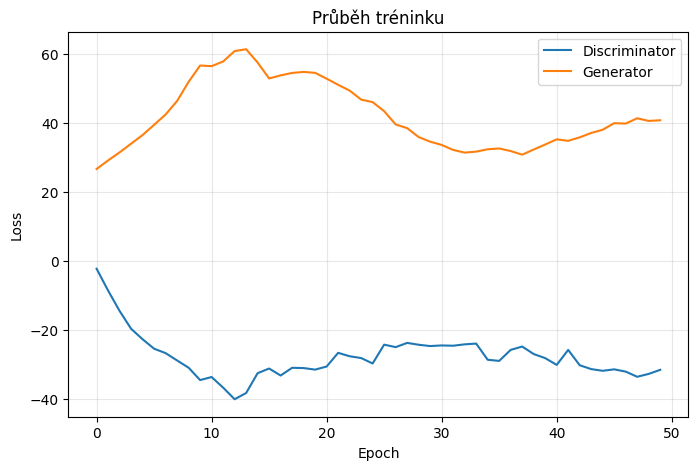

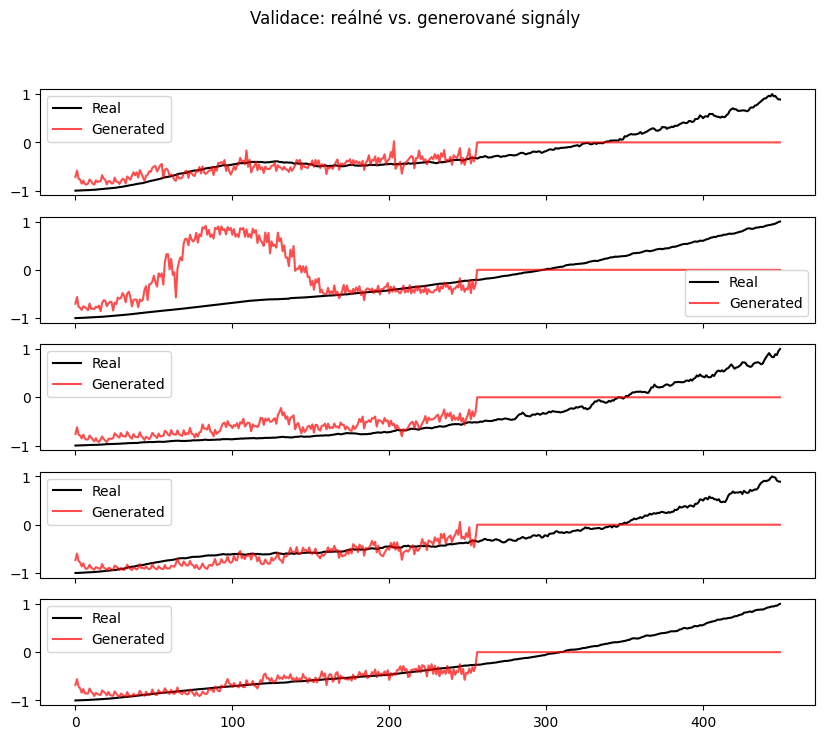

Modely uloženy do složky checkpoints/


In [10]:
import os
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader



if __name__ == "__main__":
    # ===========================
    # 1) Nastavení cesty a device
    # ===========================
    root_dir = "1D_spec"
    params_csv = os.path.join(root_dir, "params.csv")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Použité zařízení:", device)

    # složky
    os.makedirs("datasets", exist_ok=True)
    os.makedirs("checkpoints", exist_ok=True)

    # ===========================
    # 2) Rozdělení datasetu
    # ===========================
    params_df = pd.read_csv(params_csv)
    all_experiments = params_df["experiment"].unique()
    np.random.shuffle(all_experiments)

    split_ratio = 0.8
    split_idx = int(len(all_experiments) * split_ratio)
    train_exps = all_experiments[:split_idx].tolist()
    val_exps   = all_experiments[split_idx:].tolist()

    # uložíme split do datasets/
    with open("datasets/train_experiments.json", "w") as f:
        json.dump(train_exps, f, indent=2)
    with open("datasets/val_experiments.json", "w") as f:
        json.dump(val_exps, f, indent=2)

    print(f"Uloženo {len(train_exps)} trénovacích a {len(val_exps)} validačních experimentů do složky datasets/")

    # ===========================
    # 3) Dataset a DataLoader
    # ===========================
    train_dataset = Signal1DDataset(root_dir, params_csv, allowed_experiments=train_exps)
    val_dataset   = Signal1DDataset(root_dir, params_csv, allowed_experiments=val_exps)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    noise_dim = 64
    cond_dim = train_dataset[0][1].shape[0]
    signal_len = train_dataset[0][0].shape[0]

    # ===========================
    # 4) Inicializace modelů
    # ===========================
    G = Generator1D(noise_dim=noise_dim, cond_dim=cond_dim, signal_len=signal_len).to(device)
    D = Discriminator1D(cond_dim=cond_dim, signal_len=signal_len).to(device)

    # ===========================
    # 5) Trénink
    # ===========================
   # history = train_gan(G, D, train_loader, noise_dim, num_epochs=50, device=device)
    history = train_wgan_gp_l1(
    G, D, train_loader, noise_dim,
    num_epochs=50, device=device,
    lr_G=1e-4, lr_D=5e-5,
    n_critic=2, lambda_gp=1.0, lambda_l1=50.0)



    # ===========================
    # 6) Graf lossů
    # ===========================
    plt.figure(figsize=(8,5))
    plt.plot(history["loss_D"], label="Discriminator")
    plt.plot(history["loss_G"], label="Generator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Průběh tréninku")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ===========================
    # 7) Validace
    # ===========================
    validate_gan(G, val_dataset, noise_dim=noise_dim, num_samples=5, device=device)

    # ===========================
    # 8) Uložení modelů
    # ===========================
    torch.save(G.state_dict(), "checkpoints/generator_final.pth")
    torch.save(D.state_dict(), "checkpoints/discriminator_final.pth")
    print("Modely uloženy do složky checkpoints/")
